<a href="https://colab.research.google.com/github/Zhaoqi-0903/Machine-Learning-Algorithm-Implementation-using-Python/blob/main/GMM_Implementation_by_Optimizing_the_Likelihood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this implementation, we optimize parameters of an estimated Gaussian mixture model (GMM) by directly optimizing the maximum likelihood estimation (MLE).

# Data and Setup 

First, it may help to enable GPUs for the notebook:

*  Navigate to Edit→Notebook Settings
*  Select GPU from the Hardware Accelerator drop-down

Next, confirm that we can connect to the GPU with tensorflow.

(Note, it is fine if you can not connect to GPU, it just might take a little longer to run.)

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Next, we prescribe the ground truth parameters to generate data. Recall that the parameters are  𝜋𝑗 (the mixing prior coefficients for components),  𝜇𝑗 (the means for components), and  𝜎𝑗 (the standard deviation for components).  𝜋  will be represented with logits in gt_logits; 𝜇  is represented by gt_means.  𝜎  is represented in log space by gt_lsigmas; 

i.e. the softmax of gt_logits is  𝜋 . 

i.e. the exp of gt_lsigmas is  𝜎 .

In [3]:
gt_logits = tf.math.log([1/4, 1/4, 1/6, 1/6, 1/6])
gt_means = tf.convert_to_tensor([1.0, -0.5, -2, .5, 3])
gt_lsigmas = tf.math.log([.5, 1.0, .2, 0.1, .5])

First, we generate sample data based on the parameters. 

In [2]:
def make_data(N, logits, means, lsigmas):
  z = tf.transpose(tf.random.categorical([logits], N))
  y = tf.random.normal((N, 1))
  sigma = tf.math.exp(lsigmas)
  x = y * tf.gather(sigma,z)+tf.gather(means,z)
  return x

Then we plot the histogram of data.

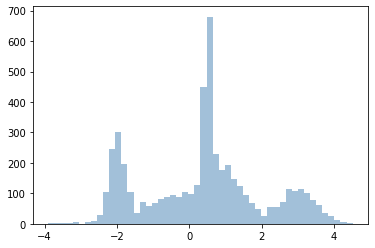

In [8]:
NUM_EXAMPLES = 5000
training_inputs = make_data(NUM_EXAMPLES, gt_logits, gt_means, gt_lsigmas)
plt.hist(np.reshape(training_inputs, [-1]), bins=50, alpha=0.5,
         histtype='stepfilled', color='steelblue', edgecolor='none');

# Likelihood based GMMs


### Mixture Likelihood

The below chunk is a function that computes the log-likelihood for data inputs given our estimated paratemters.
To be numerically stable, we choose to use `tf.reduce_logsumexp()` .

In [11]:
def mixture_likelihood(x, logits, means, lsigmas):
    """Given log-unnormalized mixture weights, shift, and log scale parameters
    for mixture components, return the likelihoods for targets.
    Args:
        x: N x 1 tensor of 1d targets to get likelihoods for.
        logits: ncomp tensor of mixing priors of mixture model.
        means: ncomp tensor of means of mixture model.
        lsigmas: ncomp tensor of log std. dev. of mixture model.
    Return:
        likelihoods: N x 1  tensor of likelihoods log p(x).
    """
    # Compute likelihoods per x
    # Write log likelihood with logsumexp.
    sigma = tf.math.exp(lsigmas)
    pdf = -1/2*((x-means)/sigma)**2 - 1/2*tf.math.log(2*np.pi*sigma**2) # logpdf take log of the pdf first
    logp = pdf+ tf.math.log(tf.nn.softmax(logits))
    return tf.reduce_logsumexp(logp,1)  # TODO

We can plot our likelihood using the ground truth parameters. The likelihood density match up with the histogram above.

In [9]:
def plot_density(logits, means, lsigmas):
  gridx = np.reshape(np.linspace(-5.0, 5.0, 1000), [-1, 1])
  log_px = mixture_likelihood(gridx, logits, means, lsigmas)
  plt.plot(gridx, np.exp(log_px))
  plt.scatter(tf.reshape(means, [-1, 1]), np.exp(mixture_likelihood(tf.reshape(means, [-1, 1]), logits, means, lsigmas)))

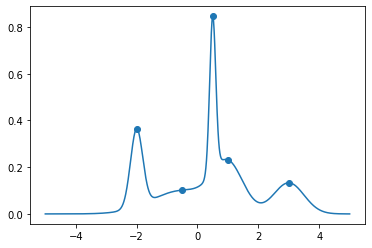

In [12]:
plot_density(gt_logits, gt_means, gt_lsigmas)

### Optimization

**Model**

First, we implement a keras model for GMMs.

In [17]:
class GMM(tf.keras.Model):
  def __init__(self, k):
    super(GMM, self).__init__()
    """
    It helps to initialize variables close to zero with a small range 
    (about 0.1 standard deviation).
    """
    #logits_float64 = tf.math.log(np.random.dirichlet(np.ones(k),size=1)[0])
    #self.logits = tf.Variable(tf.cast(logits_float64, tf.float32),name = 'logits') #TODO
    self.logits = tf.Variable(tf.random.normal([k],0,0.1),name='logits')
    self.means = tf.Variable(tf.random.normal([k],0,0.1), name='means')
    self.lsigmas = tf.Variable(tf.math.log(abs(tf.random.normal([k],0,1.1))), name='lsigmas')
    
  def call(self, inputs):
    """
    The model should return the mixture likelihood of inputs. 
    """
    return mixture_likelihood(inputs, self.logits, self.means, self.lsigmas)  # TODO

**Loss**

We implement the loss function to minimize according to gradients.

In [14]:
def loss(model, inputs):
  return -tf.reduce_sum(model(inputs)) # or can calculate the mean use tf.reduce_mean()

def grad(model,inputs):
  with tf.GradientTape() as tape:
    loss_value = loss(model,inputs)
  return tape.gradient(loss_value, model.trainable_variables)

**Train**

Lastly, we train using training data. 

Initial loss: 11956.600
Loss at step 000: 11854.918
Loss at step 100: 9251.773
Loss at step 200: 9050.289
Loss at step 300: 9014.751
Loss at step 400: 9008.730
Loss at step 500: 9005.497
Loss at step 600: 9003.795
Loss at step 700: 9002.369
Loss at step 800: 8991.670
Loss at step 900: 8260.509
Loss at step 1000: 8258.195
Loss at step 1100: 8257.938
Loss at step 1200: 8257.682
Loss at step 1300: 8257.360
Loss at step 1400: 8256.725
Loss at step 1500: 8254.257
Loss at step 1600: 8244.670
Loss at step 1700: 8233.570
Loss at step 1800: 8228.805
Loss at step 1900: 8189.928
Loss at step 2000: 8012.279
Loss at step 2100: 8011.023
Loss at step 2200: 8010.703
Loss at step 2300: 8010.520
Loss at step 2400: 8010.414
Loss at step 2500: 8010.353
Loss at step 2600: 8010.318
Loss at step 2700: 8010.300
Loss at step 2800: 8010.291
Loss at step 2900: 8010.285


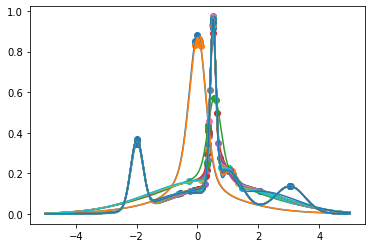

In [22]:
K = 5
model = GMM(K)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs)))
plot_density(model.logits, model.means, model.lsigmas)

steps = 3000
for i in range(steps):
  """ 
  Hint: 
  grads = something with training_inputs...
  """
  grads = grad(model,training_inputs)  # TODO
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  if i % 100 == 0:
    print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs)))
    plot_density(model.logits, model.means, model.lsigmas)

We can plot our estimate versus the ground truth to see how well they match up. 

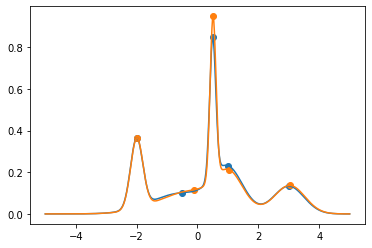

In [23]:
plot_density(gt_logits,gt_means,gt_lsigmas)
plot_density(model.logits, model.means, model.lsigmas)